In [13]:
import pandas as pd
import numpy as np
import scipy as sp
from datetime import datetime
import pickle
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.tree import DecisionTreeClassifier, plot_tree
from comparers import ModelComparer, plot_decision_boundary
from baseline import print_rules
from tasks.feature_ignored import make_task

In [2]:
clf_a, clf_b, X, y, feature_names = make_task()

In [3]:
comparer = ModelComparer(clf_a, clf_b, feature_names)

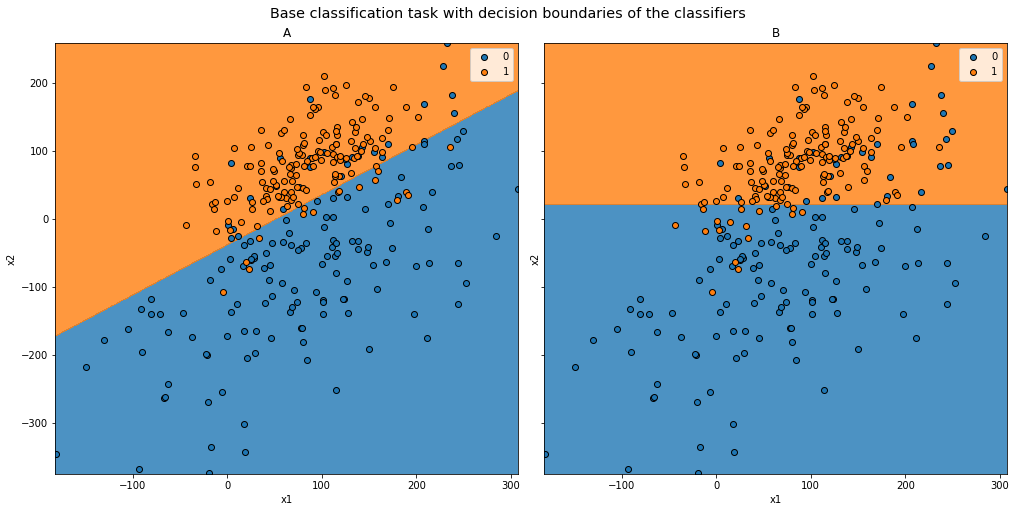

In [4]:
comparer.plot_individual_clf_decision_boundaries(X, y_true=y, kind='label')

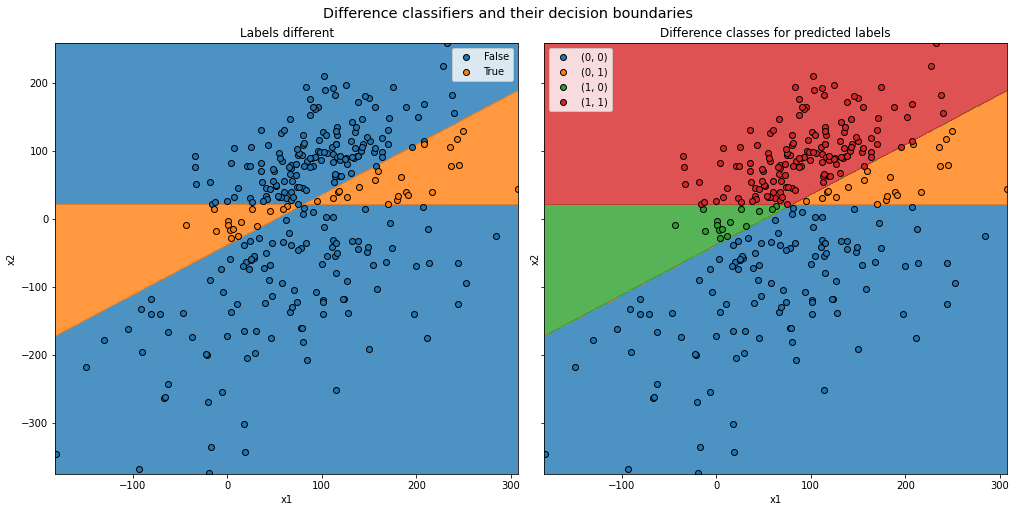

In [5]:
comparer.plot_decision_boundaries(X)

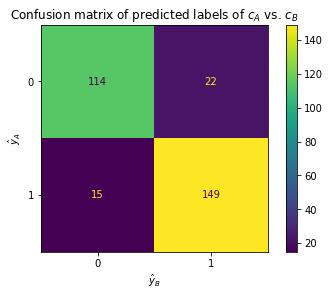

In [6]:
comparer.plot_confusion_matrix(X)

# General Explanations

In [14]:
is_pred_diff = comparer.predict_bin_diff(X)
mclass_diff = comparer.predict_mclass_diff(X)

In [20]:
mclass_tree = DecisionTreeClassifier()
mclass_tree.fit(X, mclass_diff)
class_names = comparer.class_names[mclass_tree.classes_]

In [21]:
feature_importances = mclass_tree.feature_importances_
feature_order = np.flip(np.argsort(feature_importances))

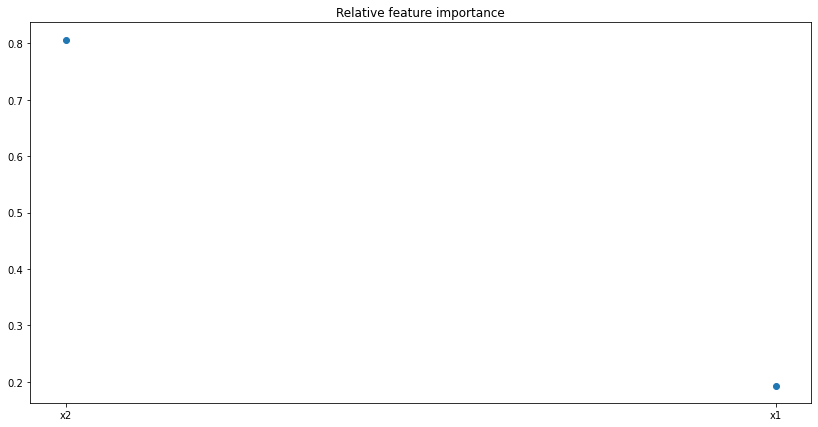

In [22]:
fig, ax = plt.subplots(figsize=(14, 7))
ax.set_title('Relative feature importance')
ax.scatter(comparer.feature_names[feature_order], feature_importances[feature_order])
plt.show()

In [23]:
class_names

array(['(0, 0)', '(0, 1)', '(1, 0)', '(1, 1)'], dtype='<U6')

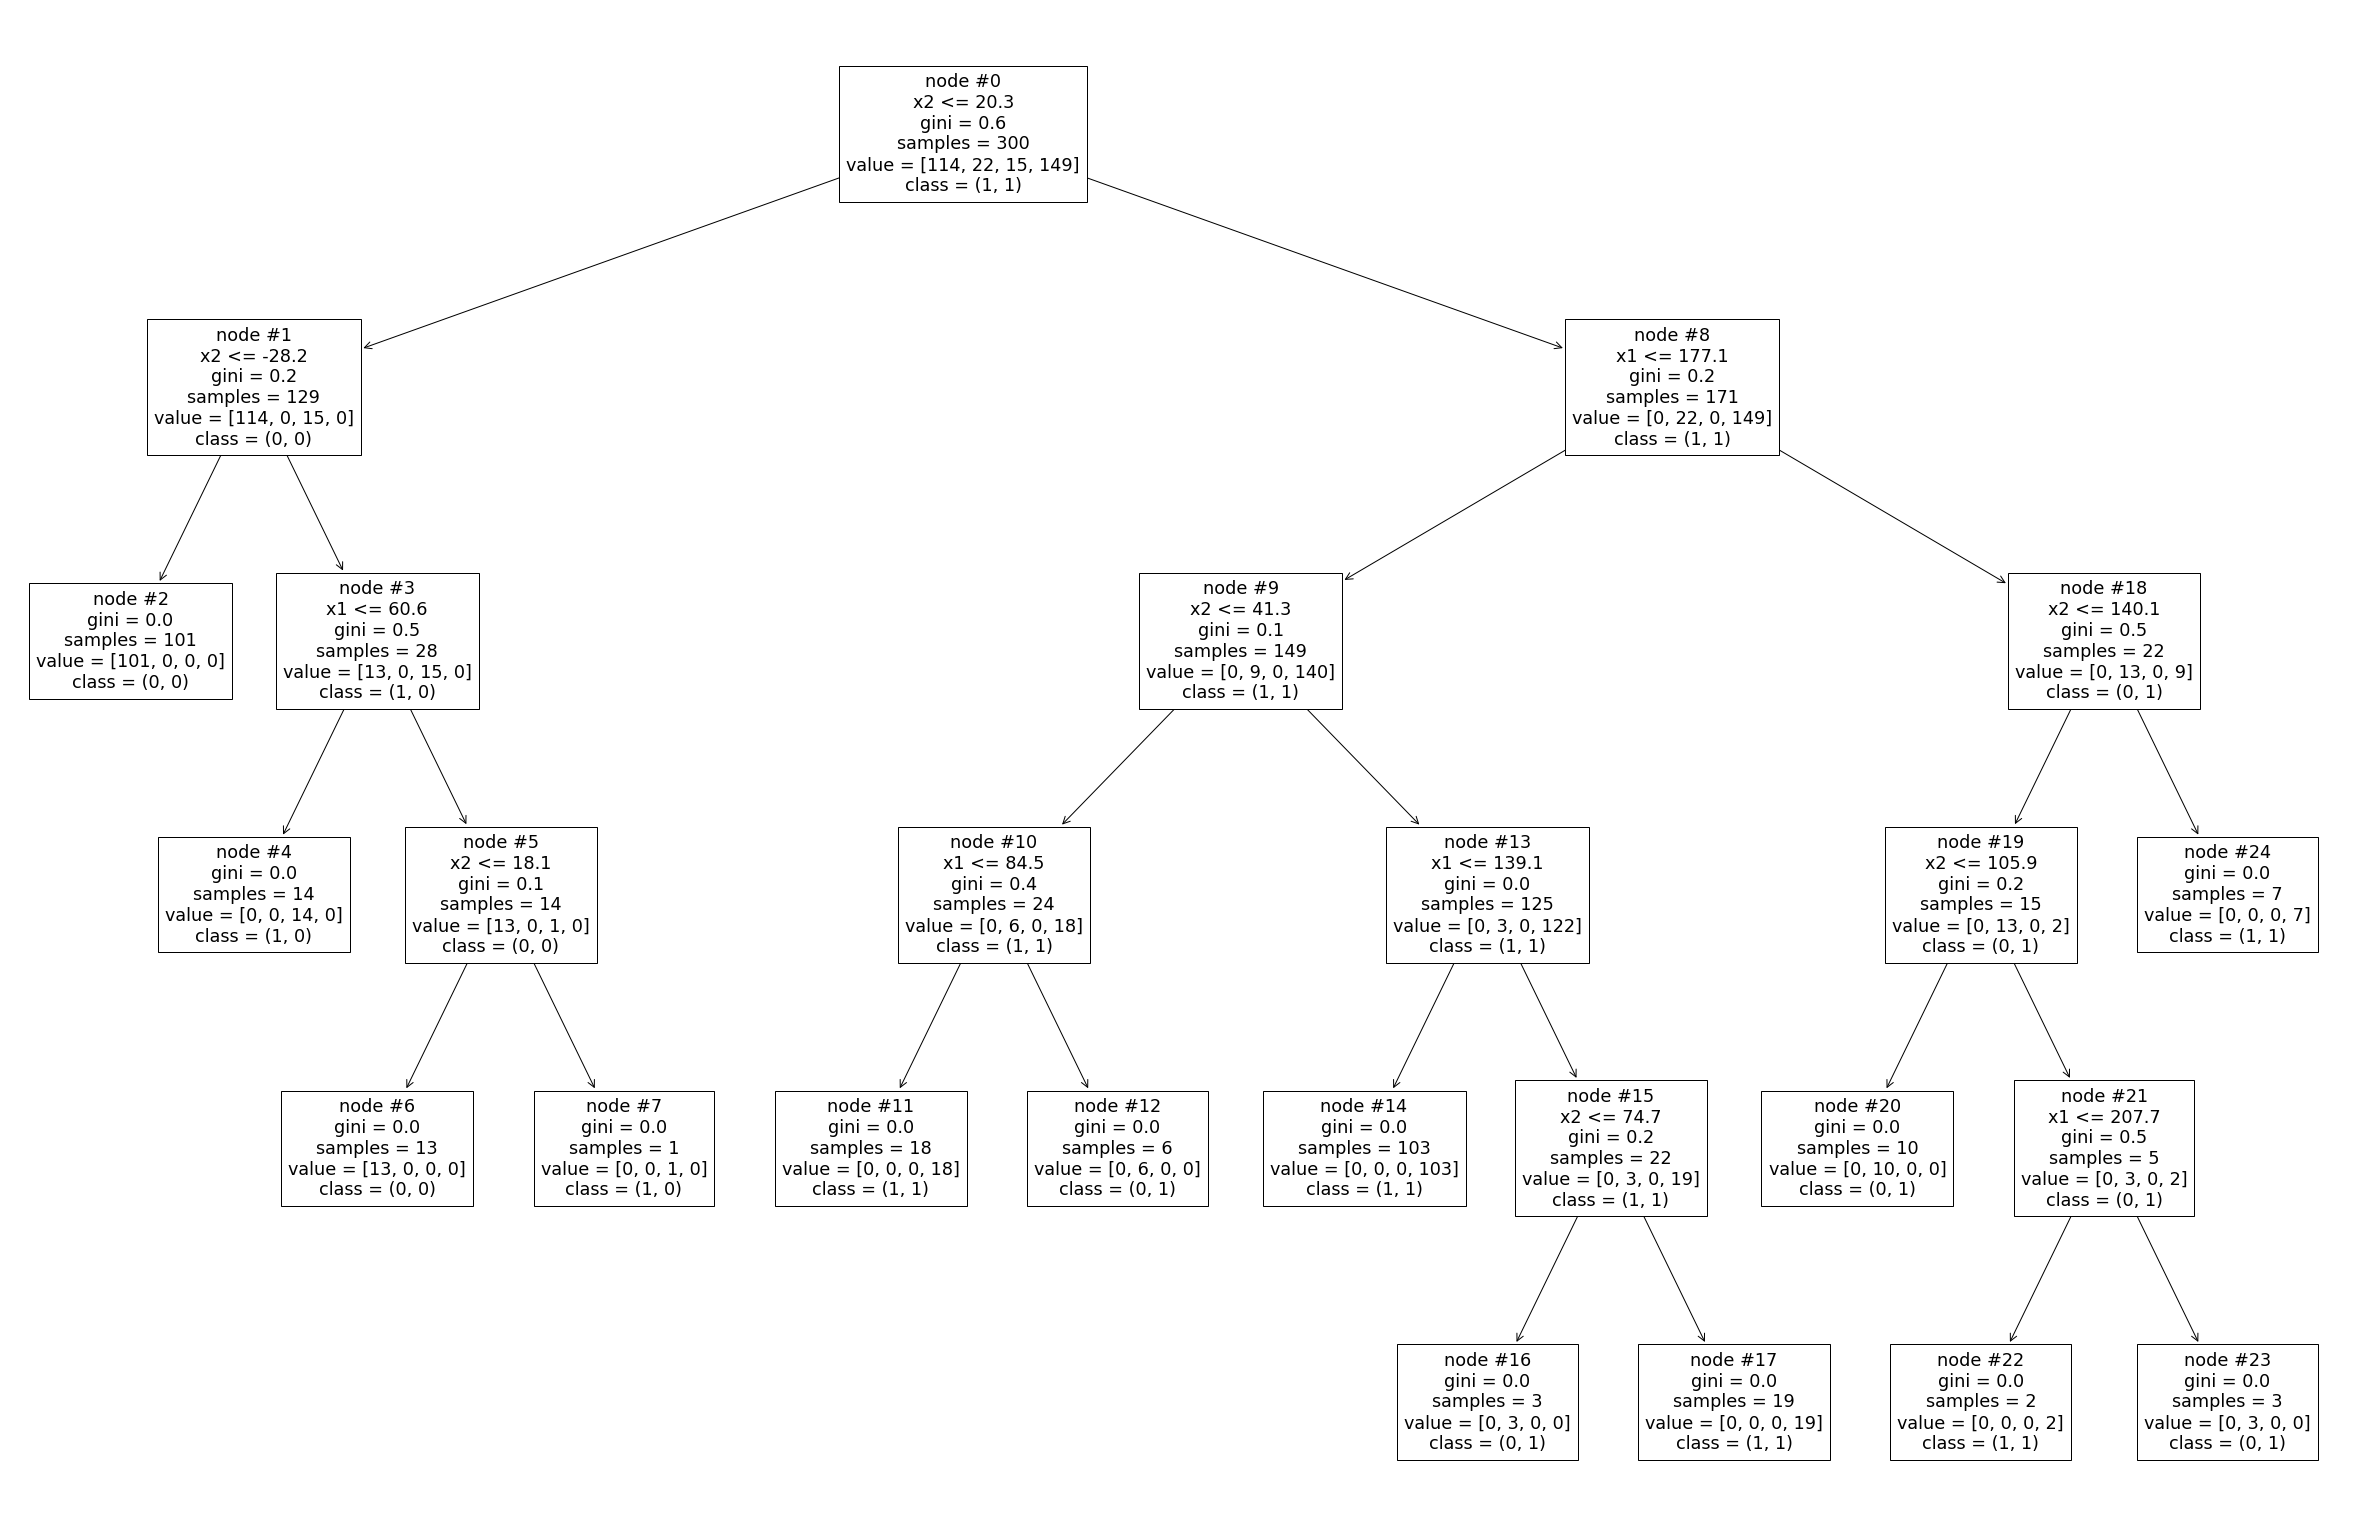

In [24]:
fig, ax = plt.subplots(figsize=(42, 28))
plot_tree(mclass_tree, feature_names=comparer.feature_names, class_names=class_names, ax=ax, precision=1, node_ids=True);

In [25]:
print_rules(mclass_tree, feature_names, class_names, '(0, 1)', feature_order, precision=2)

node #20: if (x2 > 20.33) and (x2 <= 105.92) and (x1 > 177.14) then class: (0, 1) (10/10 instances)
node #12: if (x2 > 20.33) and (x2 <= 41.29) and (x1 > 84.53) and (x1 <= 177.14) then class: (0, 1) (6/6 instances)
node #23: if (x2 > 105.92) and (x2 <= 140.13) and (x1 > 207.74) then class: (0, 1) (3/3 instances)
node #16: if (x2 > 41.29) and (x2 <= 74.68) and (x1 > 139.12) and (x1 <= 177.14) then class: (0, 1) (3/3 instances)


In [26]:
print_rules(mclass_tree, feature_names, class_names, '(1, 0)', feature_order, precision=2)

node #4: if (x2 > -28.23) and (x2 <= 20.33) and (x1 <= 60.56) then class: (1, 0) (14/14 instances)
node #7: if (x2 > 18.09) and (x2 <= 20.33) and (x1 > 60.56) then class: (1, 0) (1/1 instances)
